# Purpose

Here, we verify the Gaussian Ensemble resonance energy samplers using properties such as nearest-neighbor level-spacing, level-spacing ratio, and Dyson-Mehta $\Delta_3$ metric.

# Importing Modules

In [1]:
from math import pi, sqrt
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import TAZ

In [2]:
%matplotlib widget

# Parameters
The Dyson index, β, determines the type of Gaussian ensemble: β = 1 is the Gaussian Orthogonal Ensemble (GOE), β = 2 is the Gaussian Unitary Ensemble (GUE), and β = 4 is the Gaussian Symplectic Ensemble (GSE). 

In [3]:
beta = 1 # Dyson index
mean_level_spacing = 1.0 # mean level-spacing
energy_bounds = (0.0, 20000.0) # energy limits to sample within
seed = None # random number seed

if beta == 1:
    ensemble = 'GOE'
    print(f'β = {beta}: Gaussian Orthogonal Ensemble (GOE)')
elif beta == 2:
    ensemble = 'GUE'
    print(f'β = {beta}: Gaussian Unitary Ensemble (GUE)')
elif beta == 4:
    ensemble = 'GSE'
    print(f'β = {beta}: Gaussian Symplectic Ensemble (GSE)')
else:
    raise ValueError('The provided Dyson index is invalid. β must be 1, 2, or 4.')

β = 1: Gaussian Orthogonal Ensemble (GOE)


# Distributions

In [4]:
def wignerPDF(x, mean_level_spacing:float=1.0, beta:int=1):
    """
    Wigner Distribution PDF.
    """
    if   beta == 1:
        coef = pi/(4*mean_level_spacing**2)
        return 2*coef * x * np.exp(-coef*x**2)
    elif beta == 2:
        coef1 = 4/(pi*mean_level_spacing**2)
        coef2 = coef1 * (8/(pi*mean_level_spacing))
        return coef2 * x**2 * np.exp(-coef1*x**2)
    elif beta == 4:
        coef1 = 64/(9*pi*mean_level_spacing**2)
        coef2 = 262144/(729*pi**3*mean_level_spacing**5)
        return coef2 * x**4 * np.exp(-coef1*x**2)
    else:
        raise NotImplementedError(f'beta = {beta} has not been implemented. Choose beta = 1, 2, or 4.')

def levelSpacingRatioPDF(ratio:float, beta:int=1):
    """
    This function returns the probability density on the ensemble's nearest level-spacing ratio,
    evaluated at `ratio`. The ensemble can be chosen from GOE, GUE, and GSE for `beta` = 1, 2, or
    4, respectively.

    Source: https://arxiv.org/pdf/1806.05958.pdf (Eq. 1)

    Inputs:
    ------
    ratio :: float or float array
        The nearest level-spacing ratio(s).

    beta  :: 1, 2, or 4
        The parameter that determines the assumed ensemble. For GOE, GUE, and GSE, `beta` = 1, 2,
        or 4, respectively. The default is 1 (GOE).

    Returns:
    -------
    level_spacing_ratio_pdf :: float or float array
        The probability density (or densities) evaluated at the the provided level-spacing
        ratio(s).
    """
    if   beta == 1:
        C_beta = 27/8
    elif beta == 2:
        C_beta = 81*sqrt(3)/(4*pi)
    elif beta == 4:
        C_beta = 729*sqrt(3)/(4*pi)
    else:
        raise ValueError('"beta" can only be 1, 2, or 4.')
    level_spacing_ratio_pdf = C_beta * (ratio+ratio**2)**beta / (1+ratio+ratio**2)**(1+(3/2)*beta)
    return level_spacing_ratio_pdf

def deltaMehta3(E, EB:tuple):
    """
    Finds the Dyson-Mehta ∆3 metric for the given data.

    Source: https://arxiv.org/pdf/2011.04633.pdf (Eq. 21 & 22)

    Let `L` be the number of recorded resonances in the ladder.

    Inputs:
    ------
    E  : float [L]
        The recorded resonance energies.
    
    EB : float [2]
        The lower and upper energies for the resonance ladder.

    Returns:
    -------
    delta_3 : float
        The Dyson-Mehta ∆3 metric.
    """

    E = np.sort(E) # sort energies if not already sorted
    z = (E-EB[0])/(EB[1]-EB[0]) # renormalize energies
    s1 = np.sum(z)
    s2 = np.sum(z**2)
    a = np.arange( len(z)-1, -1, -1 )
    s3 = np.sum((2*a+1)*z)
    delta_3 = 6*s1*s2 - 4*s1**2 - 3*s2**2 + s3
    return delta_3

def predictedDeltaMehta3(n:int):
    """
    Source: http://home.ustc.edu.cn/~zegang/pic/Mehta-Random-Matrices.pdf
    """

    return pi**(-2) * (np.log(n) - 0.0687)

def levelSpacingRatioPDF(ratio:float, beta:int=1):
    """
    This function returns the probability density on the ensemble's nearest level-spacing ratio,
    evaluated at `ratio`. The ensemble can be chosen from GOE, GUE, and GSE for `beta` = 1, 2, or
    4, respectively.

    Source: https://arxiv.org/pdf/1806.05958.pdf (Eq. 1)

    Inputs:
    ------
    ratio :: float or float array
        The nearest level-spacing ratio(s).

    beta  :: 1, 2, or 4
        The parameter that determines the assumed ensemble. For GOE, GUE, and GSE, `beta` = 1, 2,
        or 4, respectively. The default is 1 (GOE).

    Returns:
    -------
    level_spacing_ratio_pdf :: float or float array
        The probability density (or densities) evaluated at the the provided level-spacing
        ratio(s).
    """
    if   beta == 1:
        C_beta = 27/8
    elif beta == 2:
        C_beta = 81*sqrt(3)/(4*pi)
    elif beta == 4:
        C_beta = 729*sqrt(3)/(4*pi)
    else:
        raise ValueError('"beta" can only be 1, 2, or 4.')
    level_spacing_ratio_pdf = C_beta * (ratio+ratio**2)**beta / (1+ratio+ratio**2)**(1+(3/2)*beta)
    return level_spacing_ratio_pdf

In [5]:
energies = TAZ.RMatrix.SampleEnergies(energy_bounds, 1/mean_level_spacing, ensemble=ensemble, seed=seed)

Calculated Dyson-Mehta ∆3 = 0.91837
Predicted Dyson-Mehta ∆3  = 0.99648



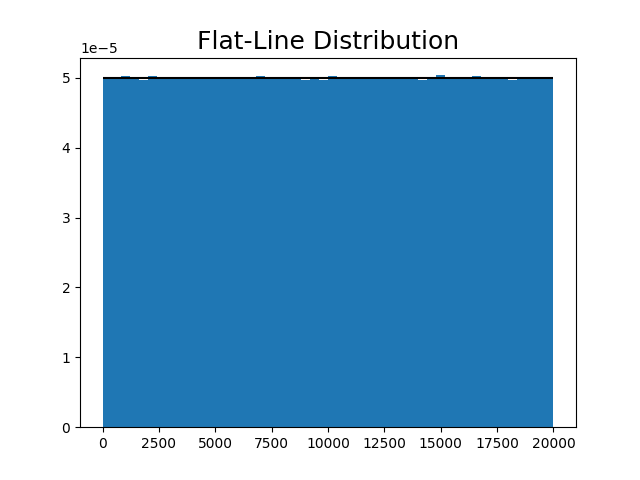

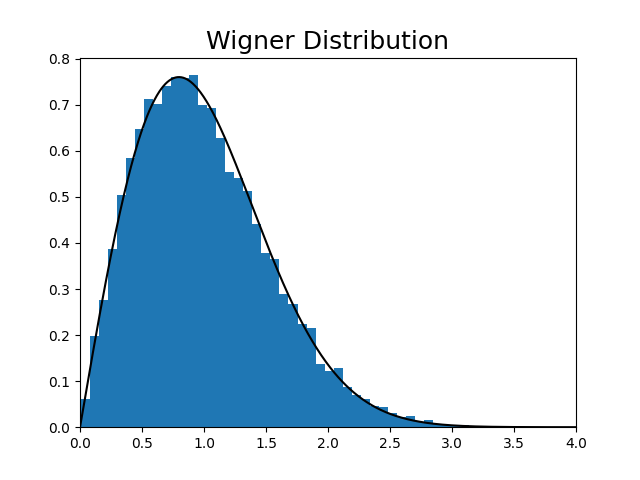

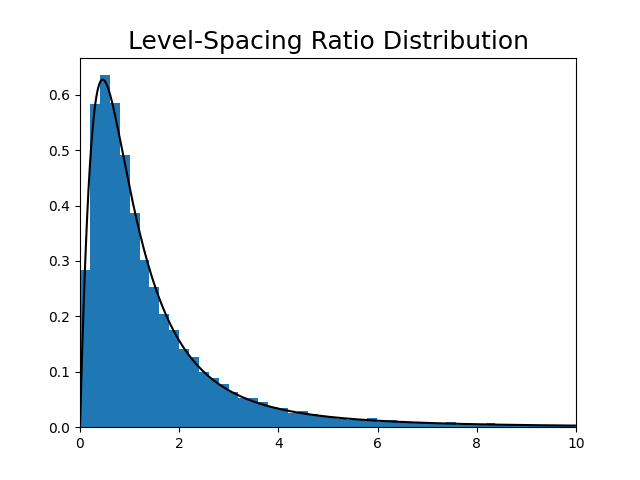

In [6]:
delta_3 = deltaMehta3(energies, energy_bounds)
delta_3_predicted = predictedDeltaMehta3(len(energies))
print(f'Calculated Dyson-Mehta ∆3 = {delta_3:.5f}')
print(f'Predicted Dyson-Mehta ∆3  = {delta_3_predicted:.5f}')
print()

plt.figure(1)
plt.clf()
plt.hist(energies, 50, density=True)
plt.hlines(1/(energy_bounds[1]-energy_bounds[0]), energy_bounds[0], energy_bounds[1], colors='k', linestyles='-')
plt.title('Flat-Line Distribution', fontsize=18)
plt.show()

X_max = 4
level_spacings = energies[1:] - energies[:-1] # level-spacing
X = np.linspace(0, X_max, 1000)
plt.figure(2)
plt.clf()
plt.hist(level_spacings, 50, density=True)
plt.plot(X, wignerPDF(X, beta=beta), '-k')
plt.xlim(0,X_max)
plt.title('Wigner Distribution', fontsize=18)
plt.show()

X_max = 10
level_spacing_ratios = level_spacings[1:]/level_spacings[:-1] # level-spacing ratios
level_spacing_ratios = level_spacing_ratios[level_spacing_ratios < X_max]
X = np.linspace(0, X_max, 1000)
plt.figure(3)
plt.clf()
plt.hist(level_spacing_ratios, 50, density=True)
plt.plot(X, levelSpacingRatioPDF(X, beta=beta), '-k')
plt.xlim(0,X_max)
plt.title('Level-Spacing Ratio Distribution', fontsize=18)
plt.show()